In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
from scipy.stats import spearmanr, mannwhitneyu
import warnings
import logomaker
import os
from function import barplot_annotate_brackets
warnings.simplefilter('ignore')

In [2]:
os.makedirs('../Figure/Supplementary Figure10', exist_ok=True)

# Load data

In [3]:
family = 'LTR7_HERVH'

Dfam_RM = pd.read_csv('../data/TE/{}.annotation.csv'.format(family))
Lift_summary_df = pd.read_csv('../data/Liftover/{}_Liftover.csv'.format(family), index_col=0)
Lift_df = pd.read_csv('../data/Liftover/{}_Liftover_rate.csv'.format(family), index_col=0)
KZFP_df = pd.read_csv('../data/overlap/{}_KZFP.csv'.format(family))
TRIM28_df = pd.read_csv('../data/overlap/{}_TRIM28.csv'.format(family))
MSA_df = pd.read_csv('../data/MSA/{}_MSA.csv'.format(family), index_col=0)
MSA_df.columns = list(map(int, MSA_df.columns))

In [4]:
# obtain binding site
motif_metadata_df = pd.read_csv('../data/motif/provirus_KZFP_binding_sites.csv')

# filtering
condition1 = (motif_metadata_df['discovery proportion']>=50) & (motif_metadata_df['log10 p-value']>=4)
condition2 = motif_metadata_df['motif start'] != motif_metadata_df['motif end']
condition3 = motif_metadata_df['repeat family name']==family
motif_metadata_df_fil = motif_metadata_df[condition1 & condition2 & condition3].sort_values(by='log10 p-value', ascending=False)

motif_metadata_df_nodup = motif_metadata_df_fil[motif_metadata_df_fil[['repeat family name', 'KZFP gene symbol']].duplicated()==False]
motif_metadata_df_nodup

,repeat family name,KZFP gene symbol,KZFP experiment,motif start,motif end,motif center,motif strand,peak overlap motif,discovery proportion,distance to peak summit,log10 p-value,E-value significant figure,E-value log10
2,LTR7_HERVH,ZNF600,GSE200964,4713.0,4726.0,4719,-,108.0,71.523179,12.000000,6.375718,9.7,286
0,LTR7_HERVH,ZNF75D,GSE78099,5549.0,5561.0,5555,-,93.0,61.589404,13.559140,6.240332,2.9,1377
1,LTR7_HERVH,ZNF735,GSE200964,3047.0,3066.0,3056,+,50.0,74.626866,12.260000,4.744727,4.4,948
5,LTR7_HERVH,ZNF705D,GSE200964,647.0,667.0,657,-,105.0,86.065574,15.361905,4.692504,7.5,1436
4,LTR7_HERVH,ZNF257,ENCSR492FKD,2417.0,2430.0,2423,-,37.0,52.857143,16.324324,4.287350,4.9,330


In [5]:
# motif

from Bio import motifs

motif_matrix_df = dict()
for KZFP, exp in motif_metadata_df_nodup[['KZFP gene symbol', 'KZFP experiment']].value_counts().index:

    with open('../data/motif/raw_motif/{}_{}_motif_sig_500_231120.meme'.format(KZFP, exp)) as f:

        fr = f.read().split('\n')

        check = False
        motif_list = list()
        for line in fr:

            if 'letter' in line:
                check = True
            
            elif check and '\t' in line:

                value = [float(i) for i in line.replace(' ', '').split('\t')[:4]]
                motif_list.append(value)
        
    df = pd.DataFrame(motif_list, columns=['A', 'C', 'G', 'T'])
    motif_matrix_df[KZFP] = df

# process data

In [6]:
# color
color_subfamily_dict = dict()
color_name_dict = dict()

color_list = ['red', 'blue', 'green', 'purple', 'orange', 'yellow', 'brown', 'pink', 'black', 'grey']
branch_list = ['Vertebrata', 'Tetrapoda', 'Amniota', 'Mammalia', 'Theria', 'Eutheria', 'Boreoeutheria', 'Euarchontoglires', 'Primatomorpha', 
               'Primates', 'Haplorrhini', 'Simiiformes', 'Catarrhini', 'Hominoidea', 'Hominidae', 'Homininae', 'Hominini']

subfamily_list = ['LTR7_HERVH_5', 'LTR7_HERVH_4', 'LTR7_HERVH_1', 'LTR7_HERVH_7', 'LTR7_HERVH_2', 'LTR7_HERVH_3', 'LTR7_HERVH_6', 'LTR7_HERVH_0']


for i, (subfamily, color) in enumerate(zip(subfamily_list, color_list)):

    color_subfamily_dict[subfamily] = color

        
for i, (subfamily, name) in enumerate(Dfam_RM[['repeat adjusted subfamily name', 'repeat name']].values):

    if subfamily not in color_subfamily_dict:

        print(subfamily)
        color_name_dict[name] = 'black'
        color_subfamily_dict[subfamily] = 'black'
        
    else:
        
        color_name_dict[name] = color_subfamily_dict[subfamily]

c_func = lambda x: color_name_dict[x.name] if x.name in color_name_dict.keys() else 'black'

# Supplementary Fig.10A

In [7]:
reorder_dict = {'LTR7_HERVH_5': 'LTR7_HERVH_1', 'LTR7_HERVH_4': 'LTR7_HERVH_2', 'LTR7_HERVH_1': 'LTR7_HERVH_3', 'LTR7_HERVH_7': 'LTR7_HERVH_4',
                'LTR7_HERVH_2': 'LTR7_HERVH_5', 'LTR7_HERVH_3': 'LTR7_HERVH_6', 'LTR7_HERVH_6': 'LTR7_HERVH_7', 'LTR7_HERVH_0': 'LTR7_HERVH_8'}

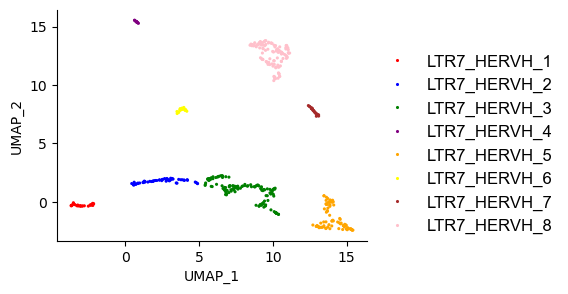

In [9]:
UMAP = pd.read_csv('../data/subfamily classification/LTR7_HERVH_trimming99_UMAP.csv', index_col=0)

fig = plt.figure(figsize=[4, 3])
ax = plt.subplot()
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.size"] = 12

data = UMAP.loc[Dfam_RM['repeat name']]
x = data['UMAP_1']
y = data['UMAP_2']
hue = Dfam_RM['repeat adjusted subfamily name'].apply(lambda x:reorder_dict[x]).values
order = reorder_dict.values()
palette = color_list[:8]

sns.scatterplot(x=x, y=y, hue=hue, hue_order=order, palette=palette, linewidth=0, s=5, ax=ax)

ax.legend(loc=[1.02, 0], frameon=False)
[ax.spines[loc].set_visible(False) for loc in ['right', 'top']]

plt.rcParams["font.family"] = "Arial"
plt.savefig('../Figure/Supplementary Figure10/Supplementary Figure10A.png', bbox_inches='tight', dpi=300)
plt.savefig('../Figure/Supplementary Figure10/Supplementary Figure10A.pdf', bbox_inches='tight', transparent=True, dpi=300)


# Supplementary Fig.10B

In [10]:
Dfam_RM.to_csv('../data/TE/{}.annotation.bed'.format(family), index=False, header=None, sep='\t')
eLife = pd.read_csv('../data/eLife_data/LTR7_annotation_by_Dfam.csv')
eLife

,eLife chr,eLife start,eLife end,eLife name,eLife family name,eLife length,eLife length class,eLife 5-LTR repeat name,eLife 5-LTR repeat family name,eLife 3-LTR repeat name,eLife 3-LTR repeat family name,eLife 5-LTR start,eLife 5-LTR end,eLife 5-LTR strand,eLife 3-LTR start,eLife 3-LTR end,eLife 3-LTR strand,eLife body start,eLife body end
0,chrY,19411964,19427738,7u1_dup13,7u1,15774,HERVH,LTR7u1_chrY_dup3,LTR7u1,LTR7u1_chrY_dup4,LTR7u1,19411965.0,19412465.0,+,19427241.0,19427739.0,+,19412465.0,19427241.0
1,chr8,12481807,12496943,7d2_dup15,7d2,15136,HERVH,LTR7d2_chr8_dup13,LTR7d2,LTR7d2_chr8_dup12,LTR7d2,12496590.0,12496943.0,-,12481801.0,12482200.0,-,12482200.0,12496590.0
2,chr8,8168723,8183856,7d2_dup14,7d2,15133,HERVH,LTR7d2_chr8_dup6,LTR7d2,LTR7d2_chr8_dup7,LTR7d2,8168723.0,8169076.0,+,8183463.0,8183862.0,+,8169076.0,8183463.0
3,chr15,88547268,88562263,7up2_dup22,7up2,14995,HERVH,LTR7up1_chr15_dup5,LTR7up1,LTR7up1_chr15_dup4,LTR7up1,88561810.0,88562263.0,-,88547266.0,88547718.0,-,88547718.0,88561810.0
4,chr11,118717034,118731855,7d1_dup191,7d1,14821,HERVH,LTR7d1_chr11_dup15,LTR7d1,LTR7d1_chr11_dup14,LTR7d1,118731444.0,118731855.0,-,118717032.0,118717442.0,-,118717442.0,118731444.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1077,chr8,126422954,126423309,7o_dup156,7o,355,solo-LTR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1078,chr11,43071243,43071597,7o_dup56,7o,354,solo-LTR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1079,chr18,38489771,38490123,7o_dup92,7o,352,solo-LTR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1080,chr17,54935084,54935436,7o_dup135,7o,352,solo-LTR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
Dfam_RM_overlap_eLife = pd.read_table('../data/eLife_data/{}.annotation_chr_fil_overlap_eLife.bed'.format(family), header=None)
Dfam_RM_overlap_eLife.columns = Dfam_RM.columns.tolist() + eLife.columns.tolist()[:7] + ['overlap']
Dfam_RM_overlap_eLife.head()
Dfam_RM_overlap_eLife

,repeat chr,repeat start,repeat end,repeat name,repeat adjusted name,repeat score,repeat strand,repeat family name,repeat subfamily name,repeat adjusted subfamily name,...,repeat adjusted cluster name,branch length,eLife chr,eLife start,eLife end,eLife name,eLife family name,eLife length,eLife length class,overlap
0,chr8,7402290,7408176,LTR7up1_HERVH_chr8_dup1,LTR7_HERVH_0_dup91,3807/5615/1079/18045/929/3860/5085/1574/2541/3874,+,LTR7_HERVH,LTR7up1_HERVH,LTR7_HERVH_0,...,LTR7_HERVH_0,0.03967,chr8,7402290,7408174,7up1_dup28,7up1,5884,HERVH,5884
1,chr6,131323296,131329139,LTR7up1_HERVH_chr6_dup8,LTR7_HERVH_0_dup85,3663/5541/16900/993/3462/4922/1495/2367/3694,+,LTR7_HERVH,LTR7up1_HERVH,LTR7_HERVH_0,...,LTR7_HERVH_0,0.04443,chr6,131323296,131329137,7up1_dup94,7up1,5841,HERVH,5841
2,chrX,125388836,125394560,LTR7up1_HERVH_chrX_dup12,LTR7_HERVH_0_dup116,3810/2515/1565/5206/3667/1058/17984/5385/4006,-,LTR7_HERVH,LTR7up1_HERVH,LTR7_HERVH_0,...,LTR7_HERVH_0,0.02513,chrX,125388838,125394560,7up1_dup124,7up1,5722,HERVH,5722
3,chr12,79539848,79545627,LTR7up1_HERVH_chr12_dup4,LTR7_HERVH_0_dup23,3962/23172/1036/3873/5257/1510/2591/4064,+,LTR7_HERVH,LTR7up1_HERVH,LTR7_HERVH_0,...,LTR7_HERVH_0,0.02060,chr12,79539848,79545625,7up1_dup162,7up1,5777,HERVH,5777
4,chr5,153449685,153455430,LTR7up1_HERVH_chr5_dup5,LTR7_HERVH_0_dup77,3739/2440/1460/4971/3611/1007/17302/4939/3716,-,LTR7_HERVH,LTR7up1_HERVH,LTR7_HERVH_0,...,LTR7_HERVH_0,0.03545,chr5,153449687,153455430,7up1_dup140,7up1,5743,HERVH,5743
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
373,chr7,30479569,30485283,LTR7BC_HERVH_chr7_dup1,LTR7_HERVH_4_dup46,2555/2033/14863/3107/9375/2976/2726,+,LTR7_HERVH,LTR7BC_HERVH,LTR7_HERVH_4,...,LTR7_HERVH_4,0.06948,chr7,30479569,30485283,7o_dup134,7o,5714,HERVH,5714
374,chr2,211261807,211267653,LTR7BC_HERVH_chr2_dup5,LTR7_HERVH_4_dup28,2528/1882/332/15337/3001/7407/1613/4041/2532,+,LTR7_HERVH,LTR7BC_HERVH,LTR7_HERVH_4,...,LTR7_HERVH_4,0.07825,chr2,211261807,211267653,7o_dup136,7o,5846,HERVH,5846
375,chr8,9802983,9809297,LTR7BC_HERVH_chr8_dup1,LTR7_HERVH_5_dup25,2639/1213/1045/295/16994/7301/1431/3783/2753,+,LTR7_HERVH,LTR7BC_HERVH,LTR7_HERVH_5,...,LTR7_HERVH_5,0.12808,chr8,9802983,9809297,7o_dup113,7o,6314,HERVH,6314
376,chr1,115509143,115515447,LTR7u2_HERVH_chr1_dup4,LTR7_HERVH_5_dup2,2292/4064/6397/645/824/2498,-,LTR7_HERVH,LTR7u2_HERVH,LTR7_HERVH_5,...,LTR7_HERVH_5,0.16459,chr1,115509141,115515447,7o_dup12,7o,6306,HERVH,6304


[102, 173, 378]


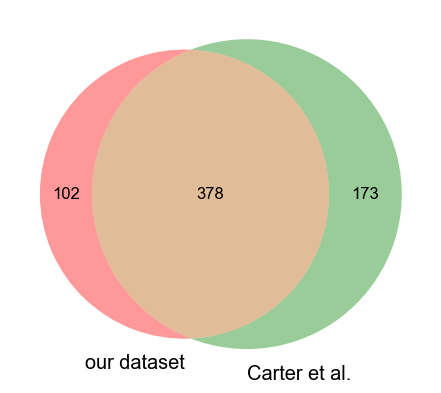

In [13]:
from matplotlib_venn import venn2

plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.size"] = 12

overlap = Dfam_RM_overlap_eLife
our_only = Dfam_RM[(Dfam_RM['repeat name'].isin(Dfam_RM_overlap_eLife['repeat name']))==False]
eLife_only = eLife[(eLife['eLife name'].isin(Dfam_RM_overlap_eLife['eLife name'])==False) & (eLife['eLife length']>=5000) & (eLife['eLife length']<=10000) & (eLife['eLife 3-LTR repeat name'].isna()==False)]

subset = [len(our_only), len(eLife_only), len(overlap)]
print(subset)
venn2(subsets=subset, set_labels = ('our dataset', 'Carter et al.'))

plt.rcParams["font.family"] = "Arial"
plt.savefig('../Figure/Supplementary Figure10/Supplementary Figure10B_ovelrap.png', bbox_inches='tight', dpi=300)
plt.savefig('../Figure/Supplementary Figure10/Supplementary Figure10B_overlap.pdf', bbox_inches='tight', transparent=True, dpi=300)


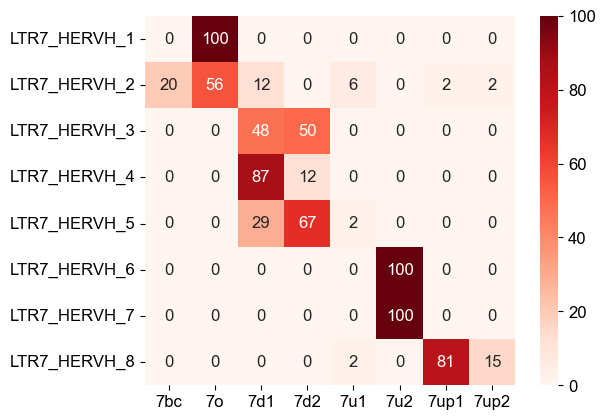

In [14]:
fig = plt.figure()
ax = plt.subplot()

plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.size"] = 12

our_subfamily_list = subfamily_list
eLife_subfamily_list = ['7bc', '7o', '7d1', '7d2', '7u1', '7u2', '7up1', '7up2']

crosstab = pd.crosstab(Dfam_RM_overlap_eLife['repeat adjusted subfamily name'], Dfam_RM_overlap_eLife['eLife family name'], normalize='index')
crosstab = crosstab.loc[subfamily_list][eLife_subfamily_list] * 100
sns.heatmap(crosstab.astype('int'), cmap='Reds', square=True, annot=True, fmt="d", ax=ax)

ax.set_yticklabels(reorder_dict.values())
ax.set_xlabel('')
ax.set_ylabel('')

plt.rcParams["font.family"] = "Arial"
plt.savefig('../Figure/Supplementary Figure10/Supplementary Figure10B_heatmap.png', bbox_inches='tight', dpi=300)
plt.savefig('../Figure/Supplementary Figure10/Supplementary Figure10B_heatmap.pdf', bbox_inches='tight', transparent=True, dpi=300)


# Supplementary Fig.10C

In [15]:
Liftover_df = pd.DataFrame(['False']*len(Lift_summary_df), index=Lift_summary_df.index, columns=['branch'])
for branch in branch_list[-6:]:

    print(branch)

    value = np.where(Lift_summary_df[branch], branch, 'False')
    Liftover_df['branch'] = np.where(Liftover_df['branch']!='False', Liftover_df['branch'], value)

Liftover_df = Liftover_df.loc[Dfam_RM['repeat name']]
Dfam_RM['branch adjusted'] = Liftover_df['branch'].values

crosstab = pd.crosstab(Dfam_RM['repeat adjusted subfamily name'], Dfam_RM['branch adjusted'], normalize='index')

Simiiformes
Catarrhini
Hominoidea
Hominidae
Homininae
Hominini


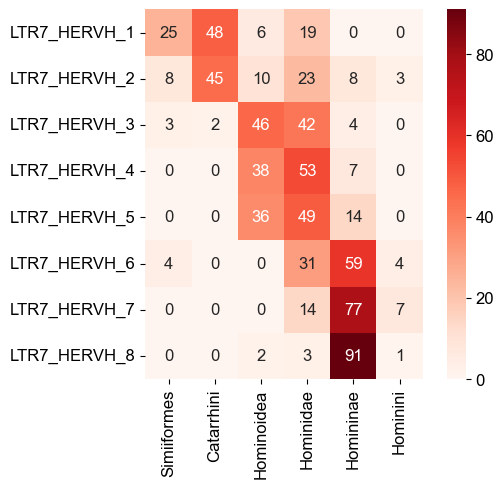

In [16]:
fig = plt.figure()
ax = plt.subplot()

plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.size"] = 12

crosstab = pd.crosstab(Dfam_RM['repeat adjusted subfamily name'].apply(lambda x:reorder_dict[x]), Dfam_RM['branch adjusted'], normalize='index') * 100
data = crosstab.loc[reorder_dict.values()][branch_list[-6:]]

sns.heatmap(data.astype('int64'), cmap='Reds', square=True, annot=True, fmt="d", ax=ax)

plt.xlabel('')
plt.ylabel('')

plt.rcParams["font.family"] = "Arial"
plt.savefig('../Figure/Supplementary Figure10/Supplementary Figure10C_heatmap.png', bbox_inches='tight', dpi=300)
plt.savefig('../Figure/Supplementary Figure10/Supplementary Figure10C_heatmap.pdf', bbox_inches='tight', transparent=True, dpi=300)


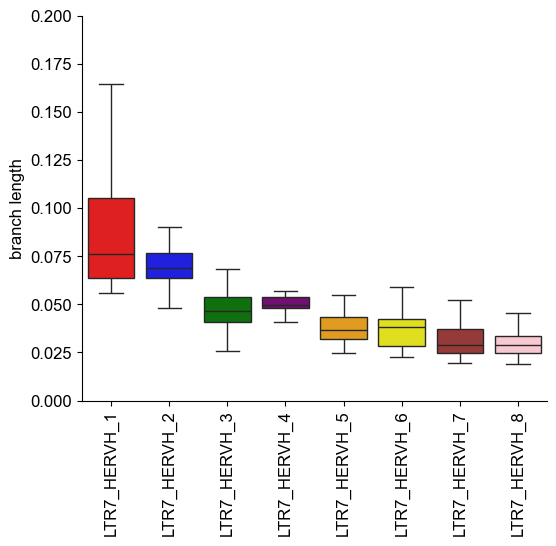

In [17]:
fig = plt.figure(figsize=[6, 5])
ax = plt.subplot()
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.size"] = 12

data = Dfam_RM
x = data['repeat adjusted subfamily name']
y = data['branch length']
order = subfamily_list

#sns.violinplot(x=x, y=y, order=order, cut=0, scale='width')
sns.boxplot(x=x, y=y, order=order, palette=color_list, flierprops={"marker": ""}, ax=ax)
#sns.stripplot(x=x, y=y, order=order, marker='o', palette=color_list, edgecolor='gray', linewidth=1, size=3, ax=ax)

ax.set_ylim(0, 0.2)
ax.set_xlabel('')
ax.set_xticklabels(reorder_dict.values(), rotation=90)
[ax.spines[loc].set_visible(False) for loc in ['right', 'top']]

plt.rcParams["font.family"] = "Arial"
plt.savefig('../Figure/Supplementary Figure10/Supplementary Figure10C_branchlength.png', bbox_inches='tight', dpi=300)
plt.savefig('../Figure/Supplementary Figure10/Supplementary Figure10C_branchlength.pdf', bbox_inches='tight', transparent=True, dpi=300)


# Supplementary Fig.10D

In [18]:
TRIM28_summit_list = [[50, 150], [795, 895], [1625, 1725], [4670, 4770], [7230, 7330], [9300, 9400]]
KZFP_list = ['ZNF184', 'ZNF534', 'ZNF75D', 'ZNF600', 'ZNF808', 'ZNF90', 'ZNF735', 'ZNF700', 'ZNF257', 'ZNF705D']

dataset_list = list()
for region in TRIM28_summit_list:

    TRIM28 = TRIM28_df[(TRIM28_df['summit position in repeat alignment']>=region[0]) & (TRIM28_df['summit position in repeat alignment']<=region[1])]
    TRIM28_count = TRIM28['repeat name'].value_counts().rename('TRIM28')

    KZFP = KZFP_df[(KZFP_df['KZFP gene symbol'].isin(KZFP_list)) & (KZFP_df['summit position in repeat alignment']>=region[0]) & (KZFP_df['summit position in repeat alignment']<=region[1])]
    KZFP_count = pd.crosstab(KZFP['repeat name'], KZFP['KZFP gene symbol'])

    data = pd.concat([Dfam_RM, TRIM28_count, KZFP_count], axis=1)
    data = data.fillna(0)

    dataset_list.append(data)

In [19]:
result_list = list()
for i, (region, data) in enumerate(zip(TRIM28_summit_list, dataset_list)):
    print(region)
    count = 0
    for k, gene in enumerate(KZFP_list):

        try:
            T = data['TRIM28']
            K = data[gene]
            r =  spearmanr(T, K)
            print(gene, K.sum(), spearmanr(T, K))
            x = i + 0.1 * count
            result_list.append([region, gene, K.sum(), r[0], r[1], -np.log10(r[1]), x])

            count += 1

        except:

            pass

result_df = pd.DataFrame(result_list, columns=['TRIM28', 'KZFP gene symbol', 'count', 'spearmanr', 'pvalue', 'log10 pvalue', 'x'])
result_df

[50, 150]
ZNF184 27.0 SignificanceResult(statistic=-0.029308681250641608, pvalue=0.5040295069172667)
ZNF735 7.0 SignificanceResult(statistic=-0.016292437058917433, pvalue=0.7103613691907882)
ZNF700 11.0 SignificanceResult(statistic=0.5222020222589808, pvalue=7.413376912959059e-38)
[795, 895]
ZNF184 6.0 SignificanceResult(statistic=0.0446475093266109, pvalue=0.22730717834756917)
ZNF534 3.0 SignificanceResult(statistic=0.04677094133233746, pvalue=0.20594076974349418)
ZNF90 110.0 SignificanceResult(statistic=0.6343835517333855, pvalue=8.578058460075659e-84)
[1625, 1725]
ZNF184 7.0 SignificanceResult(statistic=0.07063365591411795, pvalue=0.09827130051617539)
ZNF534 3.0 SignificanceResult(statistic=-0.026159934310123173, pvalue=0.5407663883996354)
ZNF705D 1.0 SignificanceResult(statistic=-0.015075858891779289, pvalue=0.7244981288077568)
[4670, 4770]
ZNF184 1.0 SignificanceResult(statistic=0.1946381033127586, pvalue=5.535094145302761e-06)
ZNF600 127.0 SignificanceResult(statistic=0.661524772

,TRIM28,KZFP gene symbol,count,spearmanr,pvalue,log10 pvalue,x
0,"[50, 150]",ZNF184,27.0,-0.029309,5.040295e-01,0.297544,0.0
1,"[50, 150]",ZNF735,7.0,-0.016292,7.103614e-01,0.148521,0.1
2,"[50, 150]",ZNF700,11.0,0.522202,7.413377e-38,37.129984,0.2
3,"[795, 895]",ZNF184,6.0,0.044648,2.273072e-01,0.643387,1.0
4,"[795, 895]",ZNF534,3.0,0.046771,2.059408e-01,0.686258,1.1
5,"[795, 895]",ZNF90,110.0,0.634384,8.578058e-84,83.066611,1.2
6,"[1625, 1725]",ZNF184,7.0,0.070634,9.827130e-02,1.007573,2.0
7,"[1625, 1725]",ZNF534,3.0,-0.026160,5.407664e-01,0.266990,2.1
8,"[1625, 1725]",ZNF705D,1.0,-0.015076,7.244981e-01,0.139963,2.2
9,"[4670, 4770]",ZNF184,1.0,0.194638,5.535094e-06,5.256875,3.0


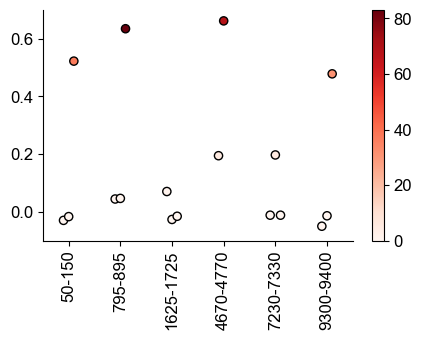

In [20]:
fig = plt.figure(figsize=[5, 3])
ax = plt.subplot()
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.size"] = 12

data = result_df
x = data['TRIM28'].apply(lambda x:'{}-{}'.format(x[0], x[1]))
x = data['x'] - 0.1
y = data['spearmanr']
color = data['log10 pvalue']

mappable = ax.scatter(x, y, c=color, vmin=0, vmax=max(color), s=35, cmap='Reds', linewidths=1, edgecolor='black')
fig.colorbar(mappable, ax=ax)

ax.set_xlim(-0.5, 5.5)
ax.set_ylim(-0.1, 0.7)
ax.set_xticklabels(labels=[''] + ['{}-{}'.format(x[0], x[1]) for x in TRIM28_summit_list], rotation=90)
#ax.set_xlabel('TRIM28 binding sites')
#ax.set_ylabel('correlation coefficient')
ax.set_ylabel('')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.rcParams["font.family"] = "Arial"
plt.savefig('../Figure/Supplementary Figure10/Supplementary Figure10D.png', bbox_inches='tight', dpi=300)
plt.savefig('../Figure/Supplementary Figure10/Supplementary Figure10D.pdf', bbox_inches='tight', transparent=True, dpi=300)


# Supplementary Fig.11E

## ZNF75D

In [21]:
gene = 'ZNF75D'

In [22]:
motif_metadata_df_nodup

,repeat family name,KZFP gene symbol,KZFP experiment,motif start,motif end,motif center,motif strand,peak overlap motif,discovery proportion,distance to peak summit,log10 p-value,E-value significant figure,E-value log10
2,LTR7_HERVH,ZNF600,GSE200964,4713.0,4726.0,4719,-,108.0,71.523179,12.000000,6.375718,9.7,286
0,LTR7_HERVH,ZNF75D,GSE78099,5549.0,5561.0,5555,-,93.0,61.589404,13.559140,6.240332,2.9,1377
1,LTR7_HERVH,ZNF735,GSE200964,3047.0,3066.0,3056,+,50.0,74.626866,12.260000,4.744727,4.4,948
5,LTR7_HERVH,ZNF705D,GSE200964,647.0,667.0,657,-,105.0,86.065574,15.361905,4.692504,7.5,1436
4,LTR7_HERVH,ZNF257,ENCSR492FKD,2417.0,2430.0,2423,-,37.0,52.857143,16.324324,4.287350,4.9,330


In [23]:
motif = motif_metadata_df_nodup[motif_metadata_df_nodup['KZFP gene symbol']==gene]
motif_start, motif_end = motif[['motif start', 'motif end']].values[0].astype('int64')

# annotation
Dfam_RM_fil = Dfam_RM[Dfam_RM['repeat adjusted subfamily name'].isin(subfamily_list)]
Dfam_RM_fil = Dfam_RM_fil.loc[reversed(Dfam_RM_fil.index)]

# MSA
MSA = MSA_df.loc[Dfam_RM_fil['repeat name']]

# KZFP
start, end = motif_start-50, motif_end+50
KZFP = KZFP_df[(KZFP_df['KZFP gene symbol']==gene) & (KZFP_df['summit position in repeat alignment']>=start) & (KZFP_df['summit position in repeat alignment']<=end) ]


In [24]:
# motif
motif_metadata = motif_metadata_df_nodup[motif_metadata_df_nodup['KZFP gene symbol']==gene]
motif = motif_matrix_df[gene][['A', 'C', 'G', 'T']]

if motif_metadata['motif strand'].values[0] == '-':

    motif = motif.sort_index(ascending=False)[['T', 'G', 'C', 'A']]

sequence = ''
for position in motif.index:

    v = motif.loc[position].sort_values(ascending=False)
    b = v.index[0]
    
    sequence += b

print(sequence)
sequence = list(sequence.lower())

TCCGAAAGGGTGT


In [25]:
# consensus sequence derived by TE copies overlapping with KZFP peaks

MSA_KZFP = MSA[MSA.index.isin(KZFP['repeat name'])]
consensus_with_KZFP = ''
consensus_matrix_with_KZFP = list()

for position in MSA_KZFP.columns:

    count = MSA_KZFP[position].value_counts(normalize=True)
    consensus_matrix_with_KZFP.append(count.rename(position))

consensus_matrix_with_KZFP = pd.concat(consensus_matrix_with_KZFP, axis=1).T.fillna(0)
consensus_matrix_with_KZFP = consensus_matrix_with_KZFP[['a', 'g', 'c', 't', '-']]
consensus_matrix_with_KZFP.columns = ['A', 'G', 'C', 'T', '-']

# remove deletion
consensus_matrix_with_KZFP_not_deletion = consensus_matrix_with_KZFP[consensus_matrix_with_KZFP['-']<0.5]
consensus_matrix_with_KZFP_not_deletion = consensus_matrix_with_KZFP_not_deletion.loc[motif_start-1:motif_end-1]
not_deletion_index = consensus_matrix_with_KZFP_not_deletion.index

consensus_with_KZFP = ''
for position in consensus_matrix_with_KZFP_not_deletion.index:
    
    count = MSA_KZFP[position].value_counts(normalize=True)
    consensus_with_KZFP += count.index[0]

In [26]:
# MSA for heatmap
heatmap = MSA.T.loc[not_deletion_index].T

for col, base in zip(heatmap.columns, consensus_with_KZFP):
    
    heatmap[col] = heatmap[col]==base

MSA.T.loc[not_deletion_index].T

,5548,5549,5550,5551,5552,5553,5554,5555,5556,5557,5558,5559,5560
LTR7C_HERVH_chrX_dup2,g,g,c,c,t,t,t,c,c,c,a,g,t
LTR7u2_HERVH_chr8_dup3,g,g,c,c,t,t,t,c,c,c,a,c,t
LTR7u2_HERVH_chr17_dup2,c,g,c,c,t,t,t,c,c,c,a,c,t
LTR7u2_HERVH_chr12_dup1,g,t,t,t,t,t,g,c,c,c,a,t,t
LTR7BC_HERVH_chr2_dup6,-,-,-,-,-,-,-,-,-,-,-,-,-
...,...,...,...,...,...,...,...,...,...,...,...,...,...
LTR7up1_HERVH_chr5_dup5,g,g,c,c,t,t,t,c,c,t,a,c,a
LTR7up1_HERVH_chr12_dup4,g,g,c,c,t,t,t,c,a,t,a,c,a
LTR7up1_HERVH_chrX_dup12,g,g,c,c,t,t,t,c,c,t,a,c,a
LTR7up1_HERVH_chr6_dup8,g,g,c,c,t,t,t,c,c,t,a,c,a


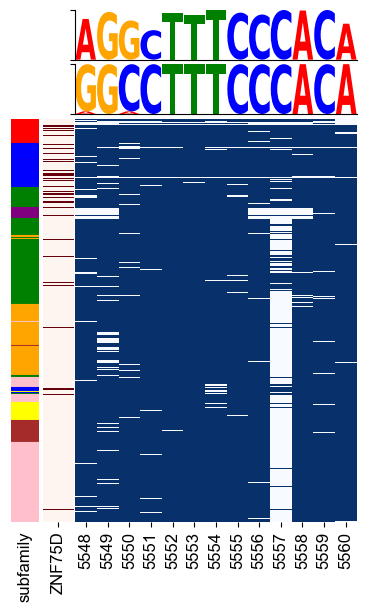

In [27]:
fig = plt.figure(figsize=[7, 7])
gs = GridSpec(20, 50)
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.size"] = 12

# subfamily
ax = plt.subplot(gs[5:, :3])
i = 3

data = Dfam_RM_fil

for k, name in enumerate(data['repeat name']):

    color = color_name_dict[name]
    y = len(data) - k
    ax.hlines(y, 0, 1, color=color)

ax.set_ylim(0, len(data))
ax.set_ylabel('')
ax.set_yticklabels([])
ax.set_xticklabels([])
ax.set_xticks([0.5])
ax.set_xticklabels(['subfamily'], rotation=90)
ax.tick_params(left=False, right=False, bottom=False, top=False)
[ax.spines[loc].set_visible(False) for loc in ['top','right','left', 'bottom']]


# binding profile
ax = plt.subplot(gs[5:, i:i+3])
i += 3

data = Dfam_RM_fil['repeat name'].isin(KZFP['repeat name']).to_frame()

sns.heatmap(data, cmap='Reds', cbar=False, ax=ax)
ax.set_xticklabels([gene], rotation=90)
ax.set_yticklabels('')
ax.set_ylabel('')
ax.tick_params(left=False)

# match with consensus
ax = plt.subplot(gs[5:, i:i+len(sequence)*2])

data = heatmap
sns.heatmap(data, cmap='Blues', cbar=False, ax=ax)

ax.set_yticklabels('')
ax.set_ylabel('')
ax.tick_params(left=False)


# motif
ax = plt.subplot(gs[1:3, i:i+len(sequence)*2])

data = (motif/0.25).apply(np.log2)
data = pd.DataFrame(np.where(data>=0, data, 0), columns=['A', 'C', 'G', 'T'])
motif_color_dict = {'A': 'red', 'T': 'green', 'C': 'blue', 'G': 'orange'}

logomaker.Logo(data, 
               color_scheme=motif_color_dict, 
               ax=ax)

ax.tick_params(bottom=False)
ax.set_xticklabels([])
ax.set_yticklabels([''])
ax.set_ylim(0, 2)
[ax.spines[loc].set_visible(False) for loc in ['top','right']]


# consensus
ax = plt.subplot(gs[3:5, i:i+len(sequence)*2])

data = consensus_matrix_with_KZFP_not_deletion[['A', 'T', 'G', 'C']]
data.index = range(len(data))
motif_color_dict = {'A': 'red', 'T': 'green', 'C': 'blue', 'G': 'orange'}

logomaker.Logo(data, 
               color_scheme=motif_color_dict, 
               ax=ax)

ax.tick_params(bottom=False)
ax.set_xticklabels([])
ax.set_yticklabels([''])
ax.set_ylim(0, 1)
[ax.spines[loc].set_visible(False) for loc in ['top','right']]

plt.rcParams["font.family"] = "Arial"
plt.savefig('../Figure/Supplementary Figure10/Supplementary Figure10E.png', bbox_inches='tight', dpi=300)
plt.savefig('../Figure/Supplementary Figure10/Supplementary Figure10E.pdf', bbox_inches='tight', transparent=True, dpi=300)

plt.show()

In [29]:
reorder_dict

{'LTR7_HERVH_5': 'LTR7_HERVH_1',
 'LTR7_HERVH_4': 'LTR7_HERVH_2',
 'LTR7_HERVH_1': 'LTR7_HERVH_3',
 'LTR7_HERVH_7': 'LTR7_HERVH_4',
 'LTR7_HERVH_2': 'LTR7_HERVH_5',
 'LTR7_HERVH_3': 'LTR7_HERVH_6',
 'LTR7_HERVH_6': 'LTR7_HERVH_7',
 'LTR7_HERVH_0': 'LTR7_HERVH_8'}

repeat name
LTR7d2_HERVH_chr11_dup1    1.5
LTR7u2_HERVH_chr1_dup1     1.5
LTR7BC_HERVH_chr8_dup3     1.0
LTR7B3_HERVH_chr8_dup1     1.0
LTR7B_HERVH_chr11_dup1     1.0
                          ... 
LTR7BC_HERVH_chr8_dup2     0.5
LTR7u2_HERVH_chr8_dup1     0.5
LTR7d2_HERVH_chr9_dup1     0.5
LTR7d2_HERVH_chr9_dup3     0.5
LTR7d2_HERVH_chr9_dup4     0.5
Name: count, Length: 88, dtype: float64

6.1167317059823244e-18


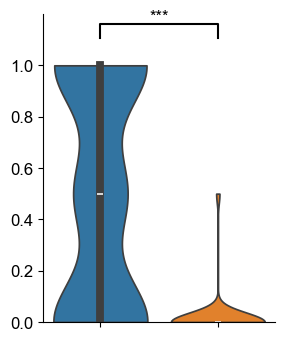

In [35]:

Dfam_RM_fil = Dfam_RM[Dfam_RM['repeat adjusted subfamily name'].isin(['LTR7_HERVH_5', 'LTR7_HERVH_4', 'LTR7_HERVH_1', 'LTR7_HERVH_7'])].copy()
Dfam_RM_fil.index = Dfam_RM_fil['repeat name']

KZFP = KZFP_df[(KZFP_df['KZFP gene symbol']==gene) & (KZFP_df['repeat name'].isin(Dfam_RM_fil['repeat name']))]
KZFP = KZFP[KZFP[['repeat adjusted name', 'KZFP accession']].duplicated()==False]
KZFP_count = KZFP['repeat name'].value_counts() / len(pd.unique(KZFP['KZFP accession']))

heatmap_fil = heatmap.loc[Dfam_RM_fil.index]

plt.figure(figsize=[3, 4])
ax = plt.subplot()
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.size"] = 12

data = pd.concat([Dfam_RM_fil, KZFP_count.rename(gene), heatmap_fil], axis=1).fillna(0)
data.head()

x = data[5557]
y = data[gene].fillna(0)
order = [True, False]

sns.violinplot(x=x, y=y, order=order, scale='width', palette=['tab:blue', 'tab:orange'], cut=0)

# 有意差
T = data[data[5557]][gene].fillna(0)
F = data[data[5557]==False][gene].fillna(0)
p = mannwhitneyu(T, F)[1]
print(p)

barplot_annotate_brackets(0, 1, p, [0, 1], [1.05, 1.05])

ax.set_ylim(-0.00, 1.2)
ax.set_xticklabels(['', ''])
ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
ax.set_xlabel('')
ax.set_ylabel('')
#ax.set_xticklabels(order, rotation=90)
[ax.spines[loc].set_visible(False) for loc in ['top','right']]

plt.rcParams["font.family"] = "Arial"
plt.savefig('../Figure/Supplementary Figure10/Supplementary Figure10F.png', bbox_inches='tight', dpi=300)
plt.savefig('../Figure/Supplementary Figure10/Supplementary Figure10F.pdf', bbox_inches='tight', transparent=True, dpi=300)
